In [9]:
#%%imports
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import polars as pl
import shutil
import subprocess
import sys
sys.path.append('../../')


from astroLuSt.database_interface import tesscut_interface as aldate
from astroLuSt.datascience import totalvariation as aldato
from astroLuSt.preprocessing import (
    images as alprim, photometry  as alprph
)
from astroLuSt.styles import plot_styles as alstps

importlib.reload(aldate)
importlib.reload(aldato)
importlib.reload(alprim)
importlib.reload(alprph)
importlib.reload(alstps)

#style for plotting
_ = alstps.tre_light()

np.random.seed(0)

# Get Data

### Sample from [DAVIS](https://davischallenge.org/davis2017/code.html) dataset

../_data/davis_aerobatics.npy already downloaded


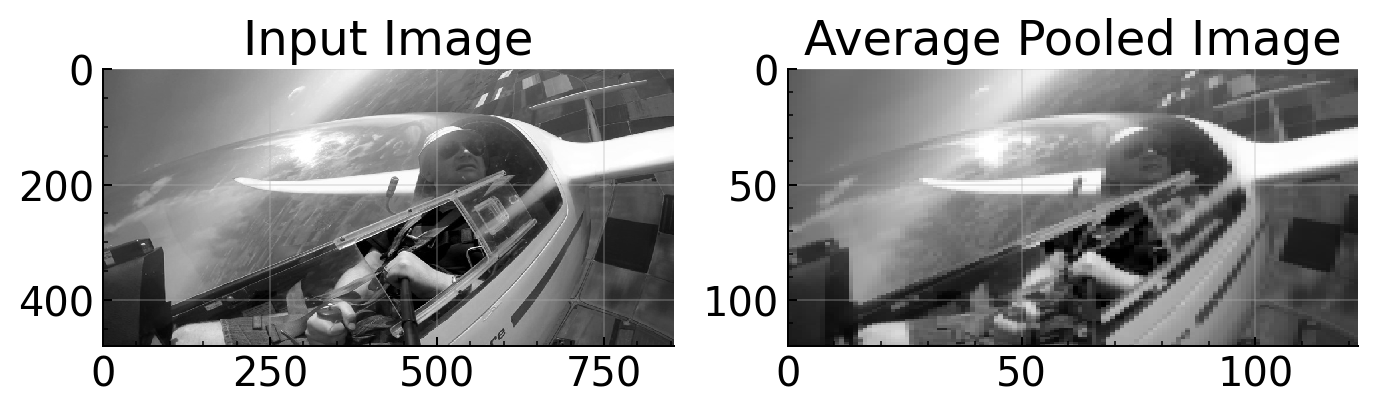

In [10]:
davis2load = "aerobatics"
davisfname = f"../_data/davis_{davis2load}.npy"
#download data if not already done
if davisfname not in glob.glob("../_data/*"):
    print(f"{davisfname} not found: downloading")
    
    #download data
    subprocess.call(["bash","./get_davis.sh"])

    #load data
    fnames = sorted(glob.glob(f"../_data/davis/DAVIS/JPEGImages/480p/{davis2load}/*.jpg"))
    X = np.array([Image.open(fn) for fn in fnames])

    ##convert to greyscale
    X = X.mean(axis=-1)/255
    np.save(davisfname, X)

    #remove downloaded data
    shutil.rmtree("../_data/davis")
    os.remove("../_data/davis.zip")
else:
    print(f"{davisfname} already downloaded")
    X = np.load(davisfname)


#average pool image for lower dimensionality
# for i in range(1,20): print(i, X.shape[2]/i)
I2P = alprim.Images2Patches(int(X.shape[2]/7),int(X.shape[1]/4))
I2P.fit(X)
X_p = I2P.transform()
X_p = np.mean(X_p, axis=(3,4))

#testplot
fig = plt.figure(figsize=(9,2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title("Input Image")
ax2.set_title("Average Pooled Image")
ax1.pcolormesh(X[0], cmap="gray")
ax2.pcolormesh(X_p[0], cmap="gray")
ax1.invert_yaxis()
ax2.invert_yaxis()


plt.show()


### Astronomical Observations

In [11]:
importlib.reload(aldate)

#define targets
df_targets = pl.from_dicts([
    dict(coords=SkyCoord("19 25 27.9129605304 +42 47 03.693258204", frame="icrs", unit=(u.hourangle, u.deg)), name="RRLyr",   sectors=[14,40],   period=0.5667732268824381),
    dict(coords=SkyCoord("14 16 36.5814789480 +42 21 35.712985824", frame="icrs", unit=(u.hourangle, u.deg)), name="TVBoo",   sectors=[1,16,23], period=0.3125589785657776),
    dict(coords=SkyCoord(327.16008333,-43.38001944,                               unit=u.deg),                name="2018evo", sectors=[1],       period=1e8),
])
display(df_targets)


#instantiate
TCI = aldate.TESScut_Interface(
    n_jobs=5,
    redownload=False,
    sleep=.5,
    verbose=1,
)

#download
hdulists = TCI.download(
    coordinates=df_targets["coords"],
    sectors=df_targets["sectors"],
    targ_ids=df_targets["name"],
    combine_sectors=True,       #combine all downloaded sectors into one array
    ffi_header_keys=["TELESCOP"],
    prim_header_keys=["TELESCOP", "INSTRUME"],
    col_keys=["SECTOR","EXPOSURE"],
    n_jobs=None,
    savedir=f"../_data/",
    # savedir=None,             #don't save
    filenames=None,             #autogenerate
    verbose=None,
    parallel_kwargs=dict(backend="threading"),
    get_cutouts_kwargs=dict(size=[15,20], product="SPOC"),
)


coords,name,sectors,period
object,str,list[i64],f64
"<SkyCoord (ICRS): (ra, dec) in deg (291.366304, 42.78435924)>","""RRLyr""","[14, 40]",0.566773
"<SkyCoord (ICRS): (ra, dec) in deg (214.15242283, 42.35992027)>","""TVBoo""","[1, 16, 23]",0.312559
"<SkyCoord (ICRS): (ra, dec) in deg (327.16008333, -43.38001944)>","""2018evo""",[1],1e8


In [12]:

#in case you already have the files downloaded
hdulists = [fits.open(f'../_data/{name}_cutouts.fits') for name in df_targets['name']]    #load in same order as input dataframe (and hence coords)
print(hdulists)
print(len(hdulists))

cutouts = [hdul[1].data.field('FLUX').copy() for hdul in hdulists]
cutouts_e = [hdul[1].data.field('FLUX_ERR').copy() for hdul in hdulists]
times = [hdul[1].data.field('TIME').copy() for hdul in hdulists]
sectors = [hdul[1].data.field('SECTOR').copy() for hdul in hdulists]

print(cutouts[0].shape, cutouts_e[0].shape)

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7a124418c580>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7a1234bde8c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7a1234bde380>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7a13001ba5c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7a1234bddb10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7a1234bdc520>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7a1234bdc760>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7a1234bdd540>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7a1234bdd2a0>]]
3
(5168, 15, 20) (5168, 15, 20)


# Total Variation

## Applied to Images

### Salt and Pepper Noise

In [13]:
def rand_salt_pepper(X:np.ndarray, t:float=0.2):
    """
        - function to add salt & pepper noise onto an image

        Parameters
        ----------
            - `X`
                - `np.ndarray`
                - array to add noise to
            - `t`
                - `float`, optional
                - threshold value
                - this fraction will be corrupted with zeros and ones
                - both zeros and ones will occur about equally often
        
        Raises
        ------

        Returns
        -------
            - `X`
                - `np.ndarray`
                - noisy version of `X`

        Dependencies
        ------------
            - `numpy`
        
        Comments
        --------
    """    
    n = np.random.rand(*X.shape)
    X[n <= t/2] = 0.0
    X[n >= (1-t/2)] = 1.0
    
    return X

INFO(TotalVariation.fit): Iteration 1 with delta= 0.0e+00, energy= 4.94e+03.
INFO(TotalVariation.fit): Iteration 2 with delta= 0.0e+00, energy= 4.94e+03.
INFO(TotalVariation.fit): Iteration 3 with delta= 2.2e-01, energy= 3.87e+03.
INFO(TotalVariation.fit): Iteration 4 with delta= 1.2e-01, energy= 3.42e+03.
INFO(TotalVariation.fit): Iteration 5 with delta= 9.9e-02, energy= 3.76e+03.
INFO(TotalVariation.fit): Iteration 6 with delta= 5.7e-02, energy= 3.54e+03.
INFO(TotalVariation.fit): Iteration 7 with delta= 1.7e-01, energy= 2.95e+03.
INFO(TotalVariation.fit): Iteration 8 with delta= 1.3e-01, energy= 2.57e+03.
INFO(TotalVariation.fit): Iteration 9 with delta= 7.7e-02, energy= 2.37e+03.
INFO(TotalVariation.fit): Iteration 10 with delta= 6.1e-02, energy= 2.23e+03.
INFO(TotalVariation.fit): Iteration 11 with delta= 4.3e-02, energy= 2.13e+03.
INFO(TotalVariation.fit): Iteration 12 with delta= 2.2e-02, energy= 2.09e+03.
INFO(TotalVariation.fit): Iteration 13 with delta= 1.2e-02, energy= 2.06e

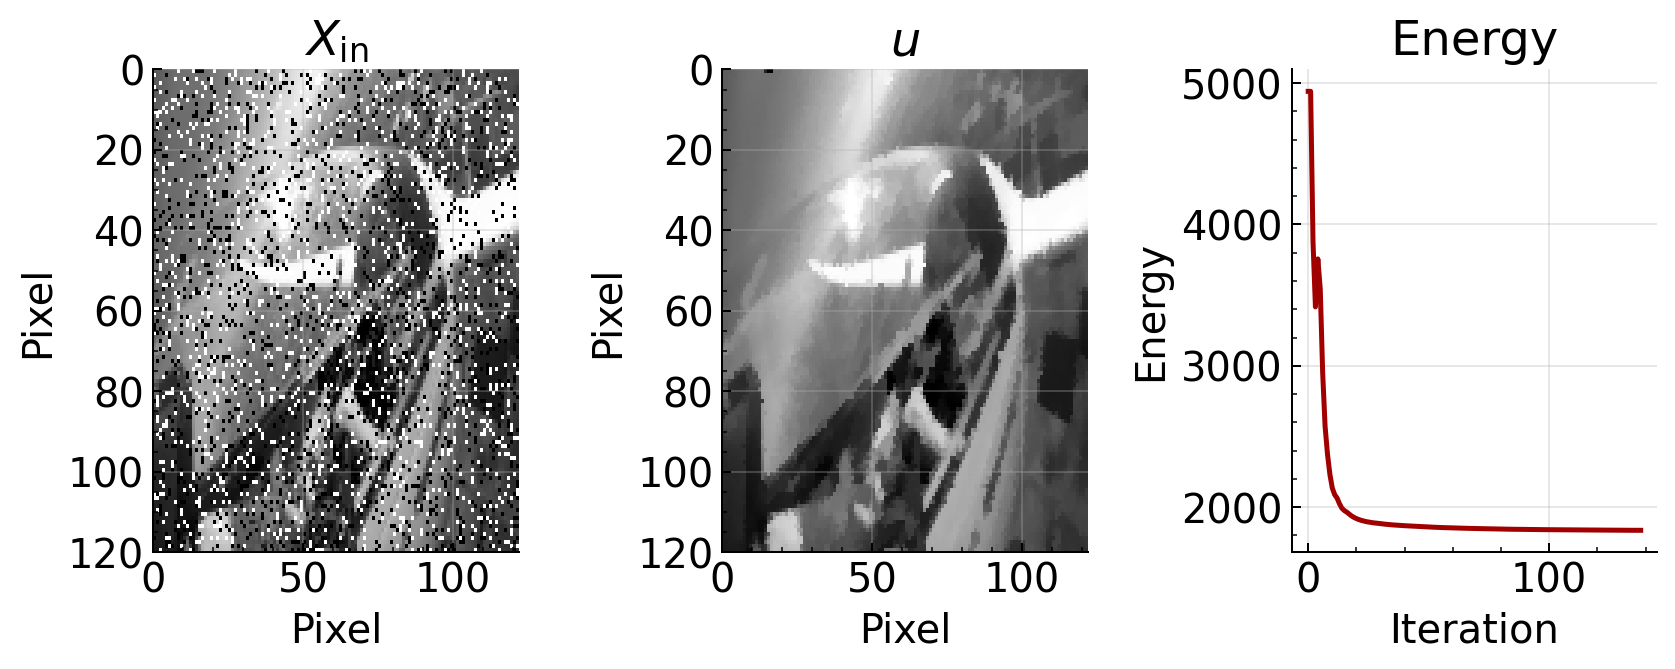

In [14]:
importlib.reload(aldato)
X = X_p[0]
X_noisy = rand_salt_pepper(X.copy(), t=0.2)
TV = aldato.TotalVariation(
    lbda=1.5, tau=1/np.sqrt(8),
    theta=1,
    norm="l1",
    min_iter=2, max_iter=500, eps=1e-6,
    verbose=3,
)

TV.fit(X_noisy)
u = TV.transform()

fig = plt.figure(figsize=(12,4))
fig, axs = TV.plot_result(X_in=X_noisy, fig=fig)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
fig.tight_layout()
plt.show()



### Gaussian Noise

INFO(TotalVariation.fit): Iteration 1 with delta= 0.0e+00, energy= 2.82e+03.
INFO(TotalVariation.fit): Iteration 2 with delta= 2.5e-01, energy= 2.10e+03.
INFO(TotalVariation.fit): Iteration 3 with delta= 6.5e-02, energy= 1.96e+03.
INFO(TotalVariation.fit): Iteration 4 with delta= 4.1e-02, energy= 1.88e+03.
INFO(TotalVariation.fit): Iteration 5 with delta= 2.7e-02, energy= 1.83e+03.
INFO(TotalVariation.fit): Iteration 6 with delta= 1.9e-02, energy= 1.80e+03.
INFO(TotalVariation.fit): Iteration 7 with delta= 1.3e-02, energy= 1.78e+03.
INFO(TotalVariation.fit): Iteration 8 with delta= 8.8e-03, energy= 1.76e+03.
INFO(TotalVariation.fit): Iteration 9 with delta= 6.3e-03, energy= 1.75e+03.
INFO(TotalVariation.fit): Iteration 10 with delta= 4.5e-03, energy= 1.74e+03.
INFO(TotalVariation.fit): Iteration 11 with delta= 3.2e-03, energy= 1.74e+03.
INFO(TotalVariation.fit): Iteration 12 with delta= 2.4e-03, energy= 1.73e+03.
INFO(TotalVariation.fit): Iteration 13 with delta= 1.7e-03, energy= 1.73e

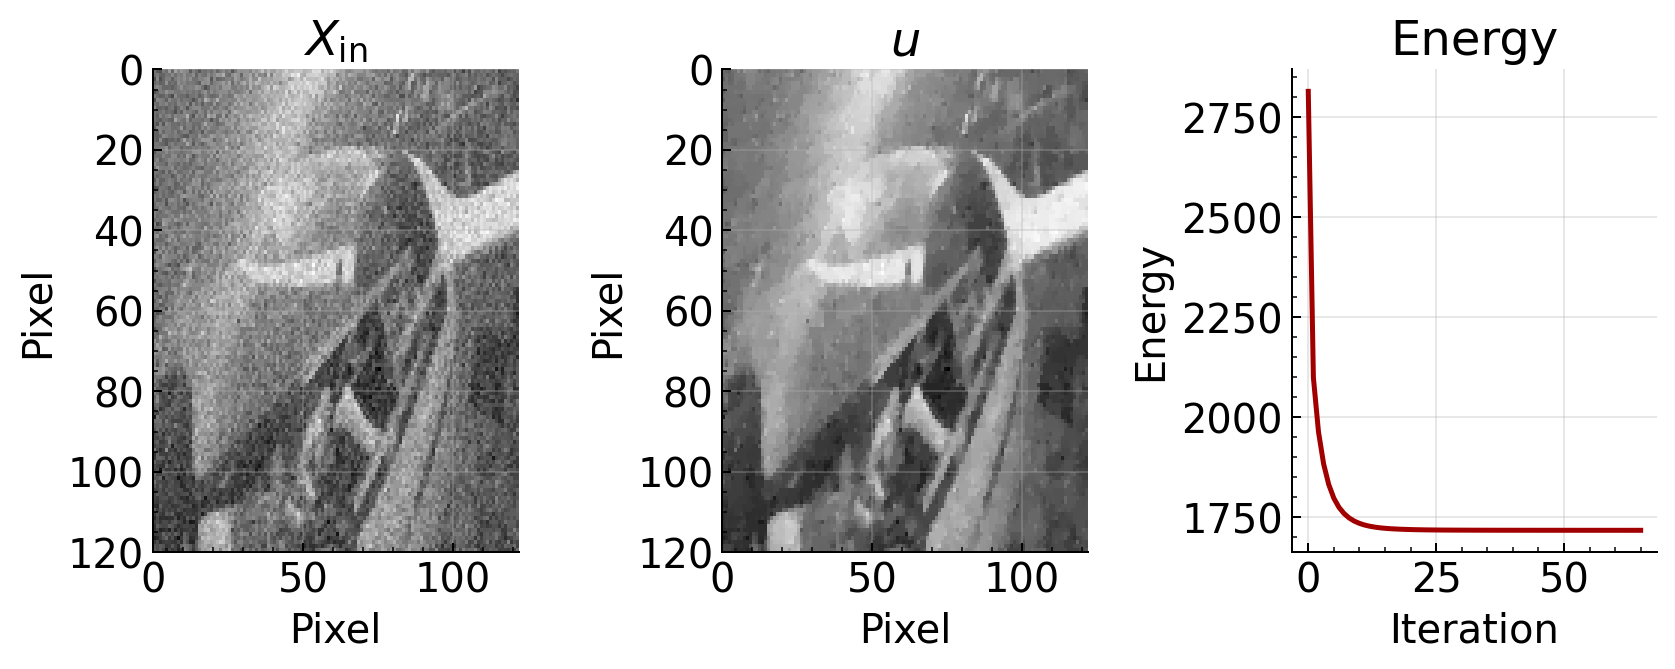

In [15]:
importlib.reload(aldato)
X = X_p[0]
X_noisy = X.copy() + 0.1*np.random.normal(size=X.shape)
TV = aldato.TotalVariation(
    lbda=20, tau=.01,
    theta=1,
    norm="l2",
    min_iter=1, max_iter=500, eps=1e-6,
    verbose=3,
)

TV.fit(X_noisy)
u = TV.transform()

fig = plt.figure(figsize=(12,4))
fig, axs = TV.plot_result(X_in=X_noisy, fig=fig)
axs[0].invert_yaxis()
axs[1].invert_yaxis()
fig.tight_layout()
plt.show()



## Applied to Astronomical Observations
* Note that for the fist second panels in the LC-figures, no aperture has been applied!

INFO(TotalVariation.fit): Finished after 100 iterations with delta=2.4e-04, energy= 1.41e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=1.0e-04, energy= 1.53e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=1.9e-04, energy= 1.91e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=3.5e-04, energy= 2.16e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=2.5e-04, energy= 2.32e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=2.8e-04, energy= 2.26e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=3.4e-04, energy= 2.17e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=2.1e-04, energy= 2.10e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=3.2e-04, energy= 2.03e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with delta=2.3e-04, energy= 1.98e+05.
INFO(TotalVariation.fit): Finished after 100 iterations with

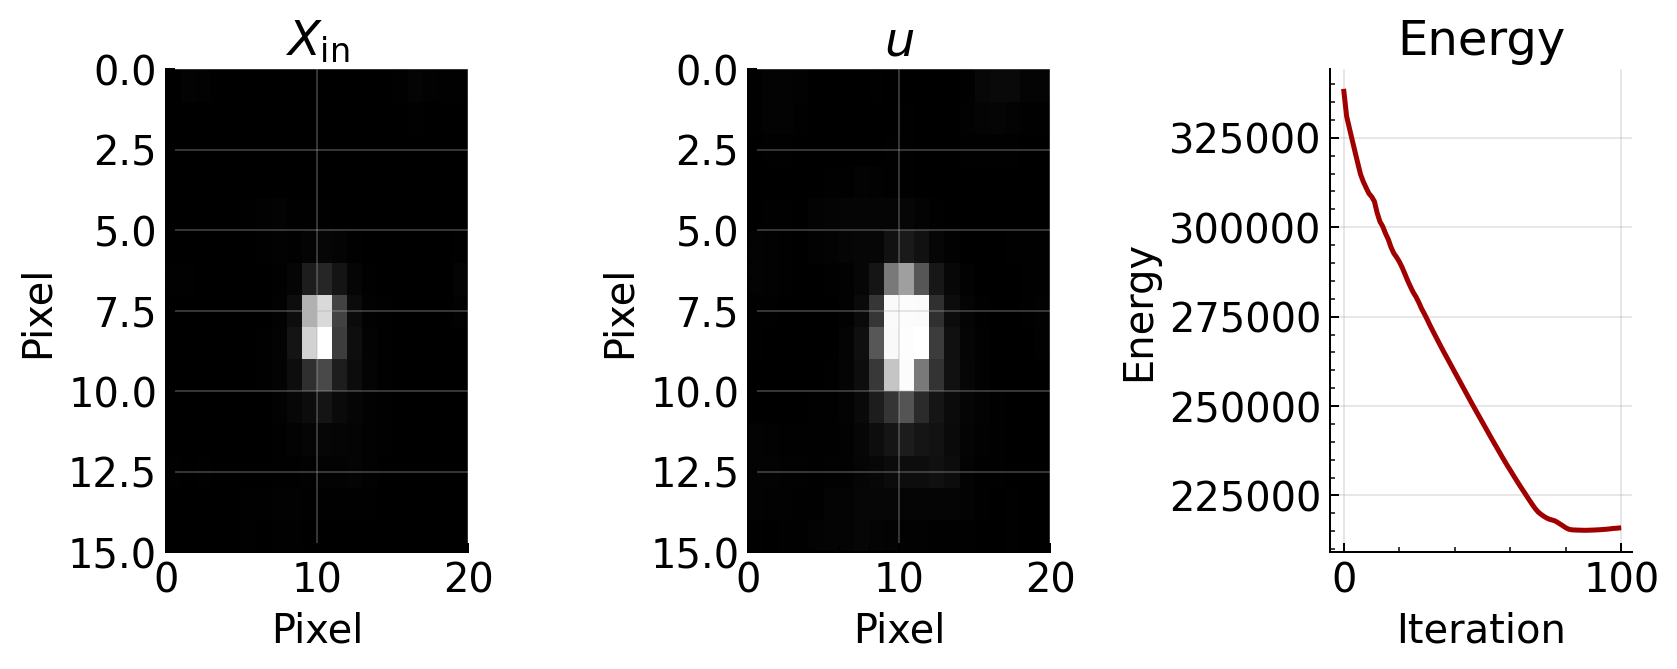

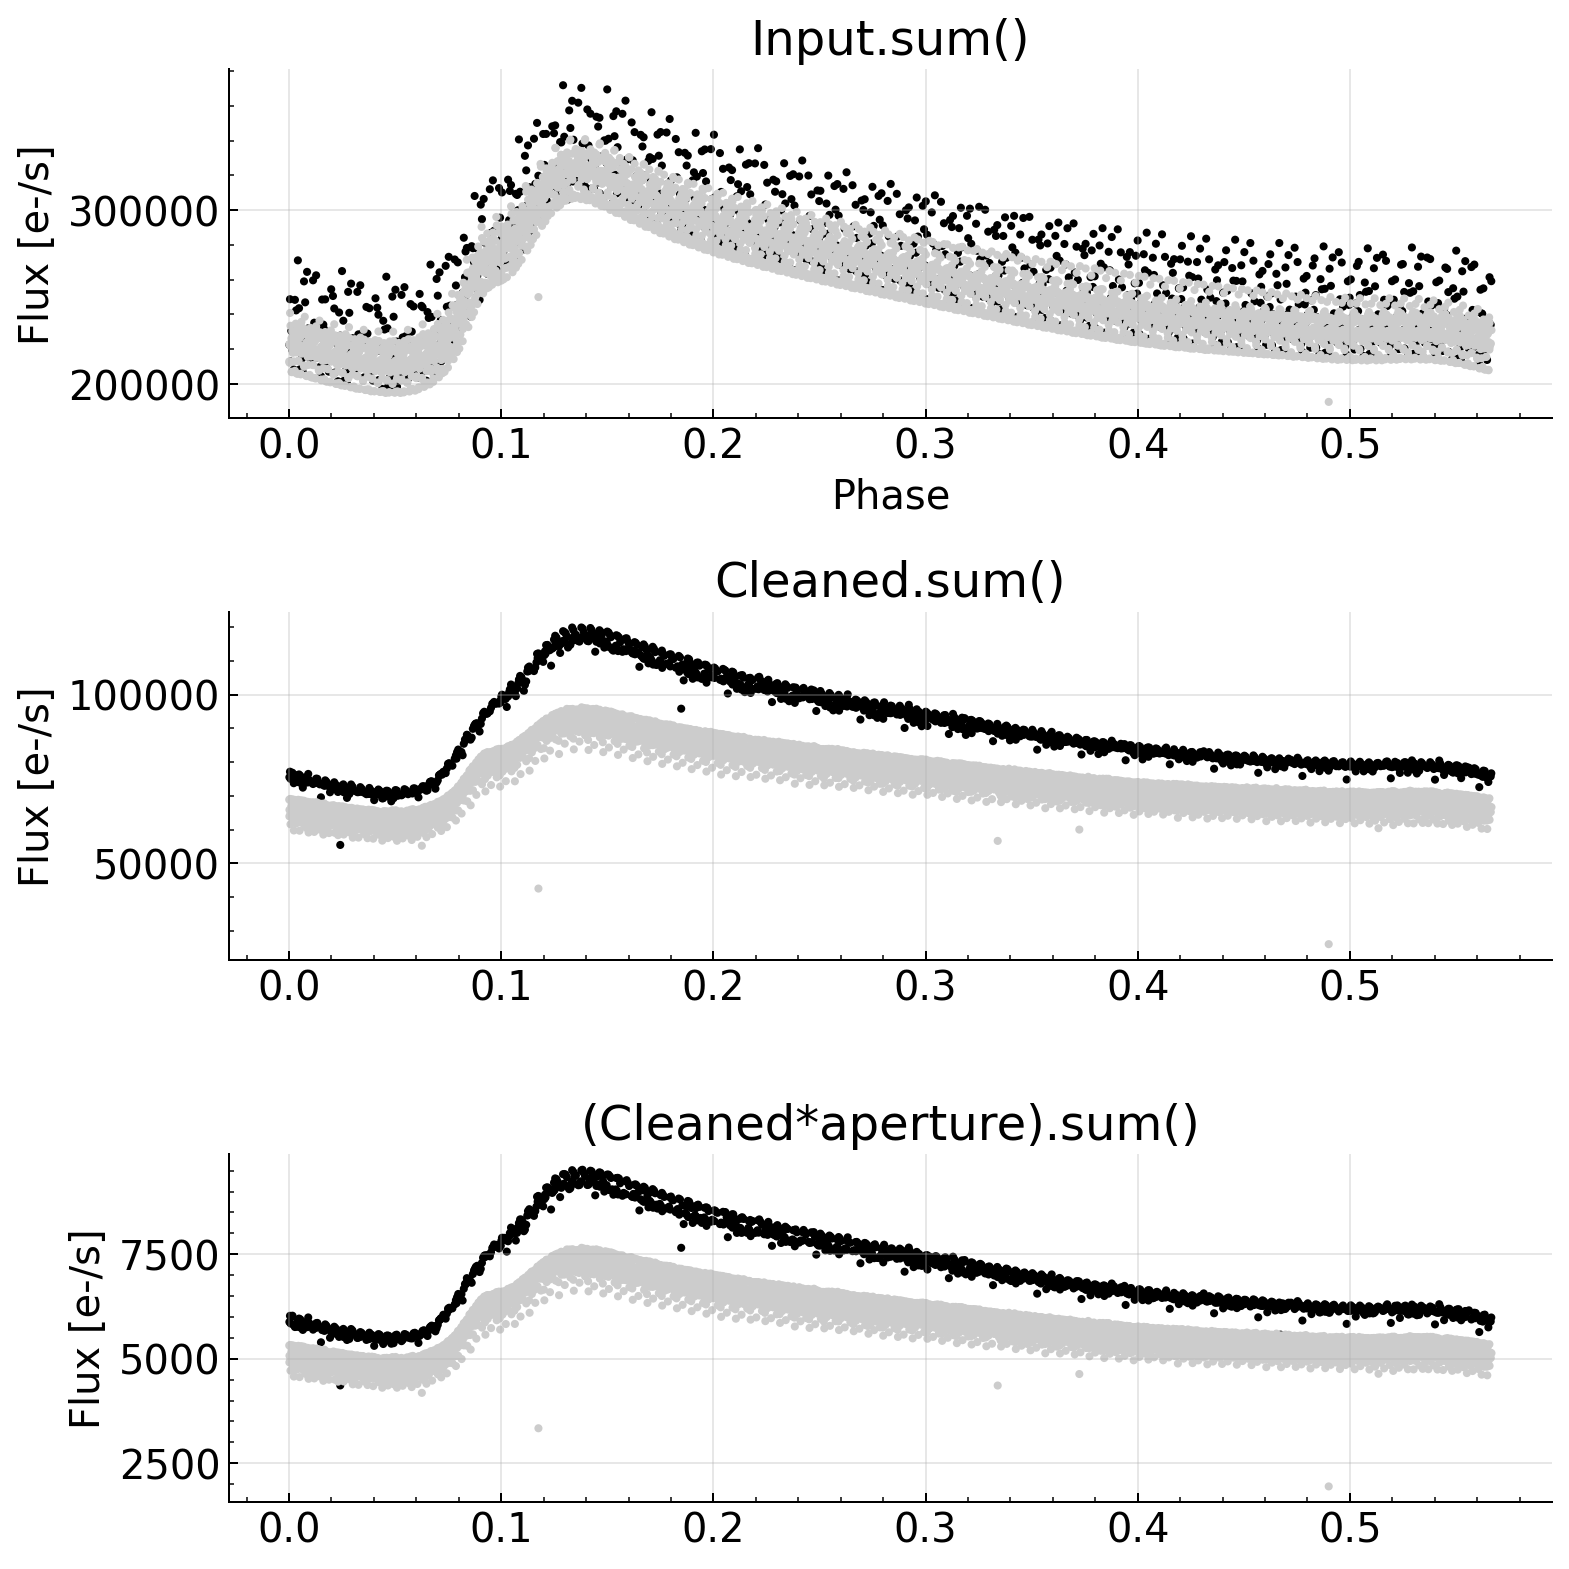

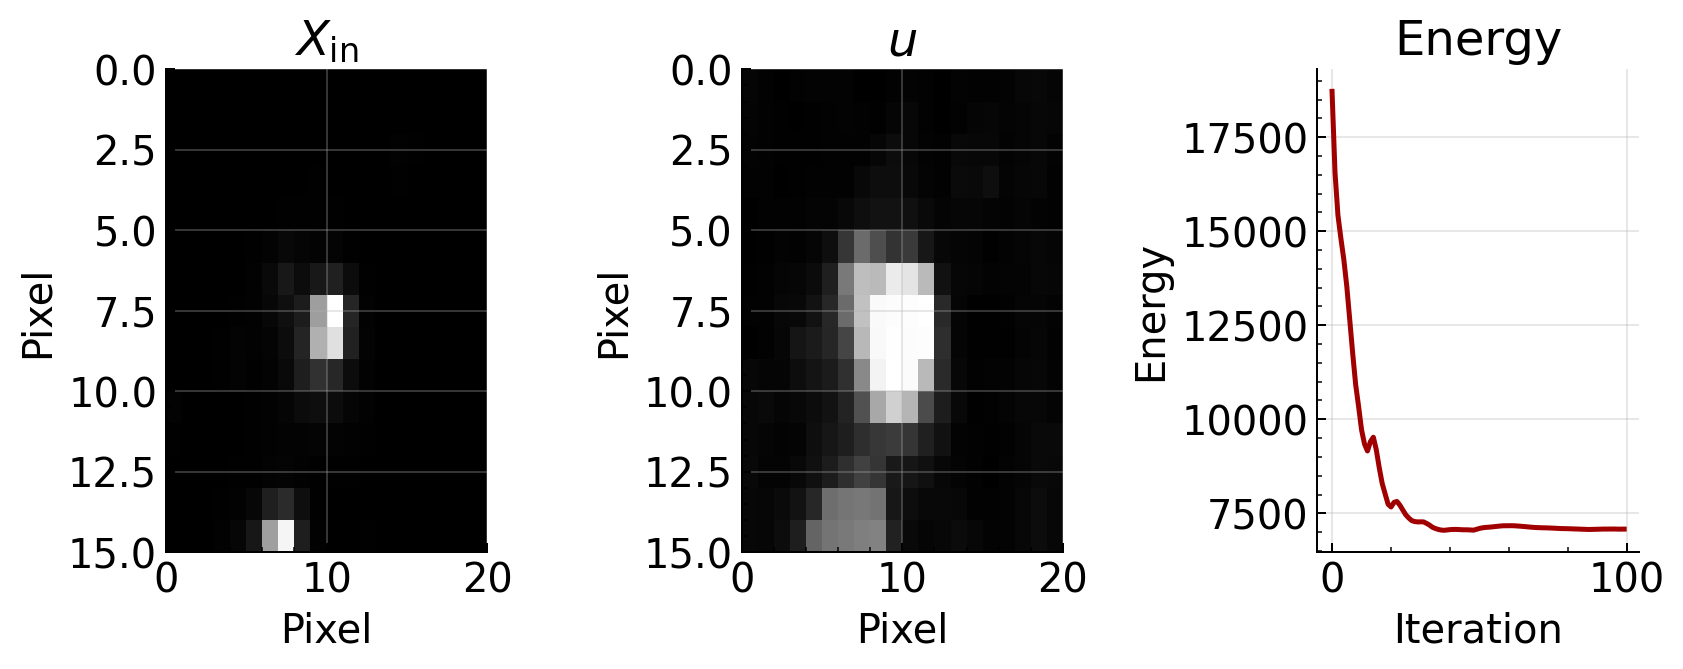

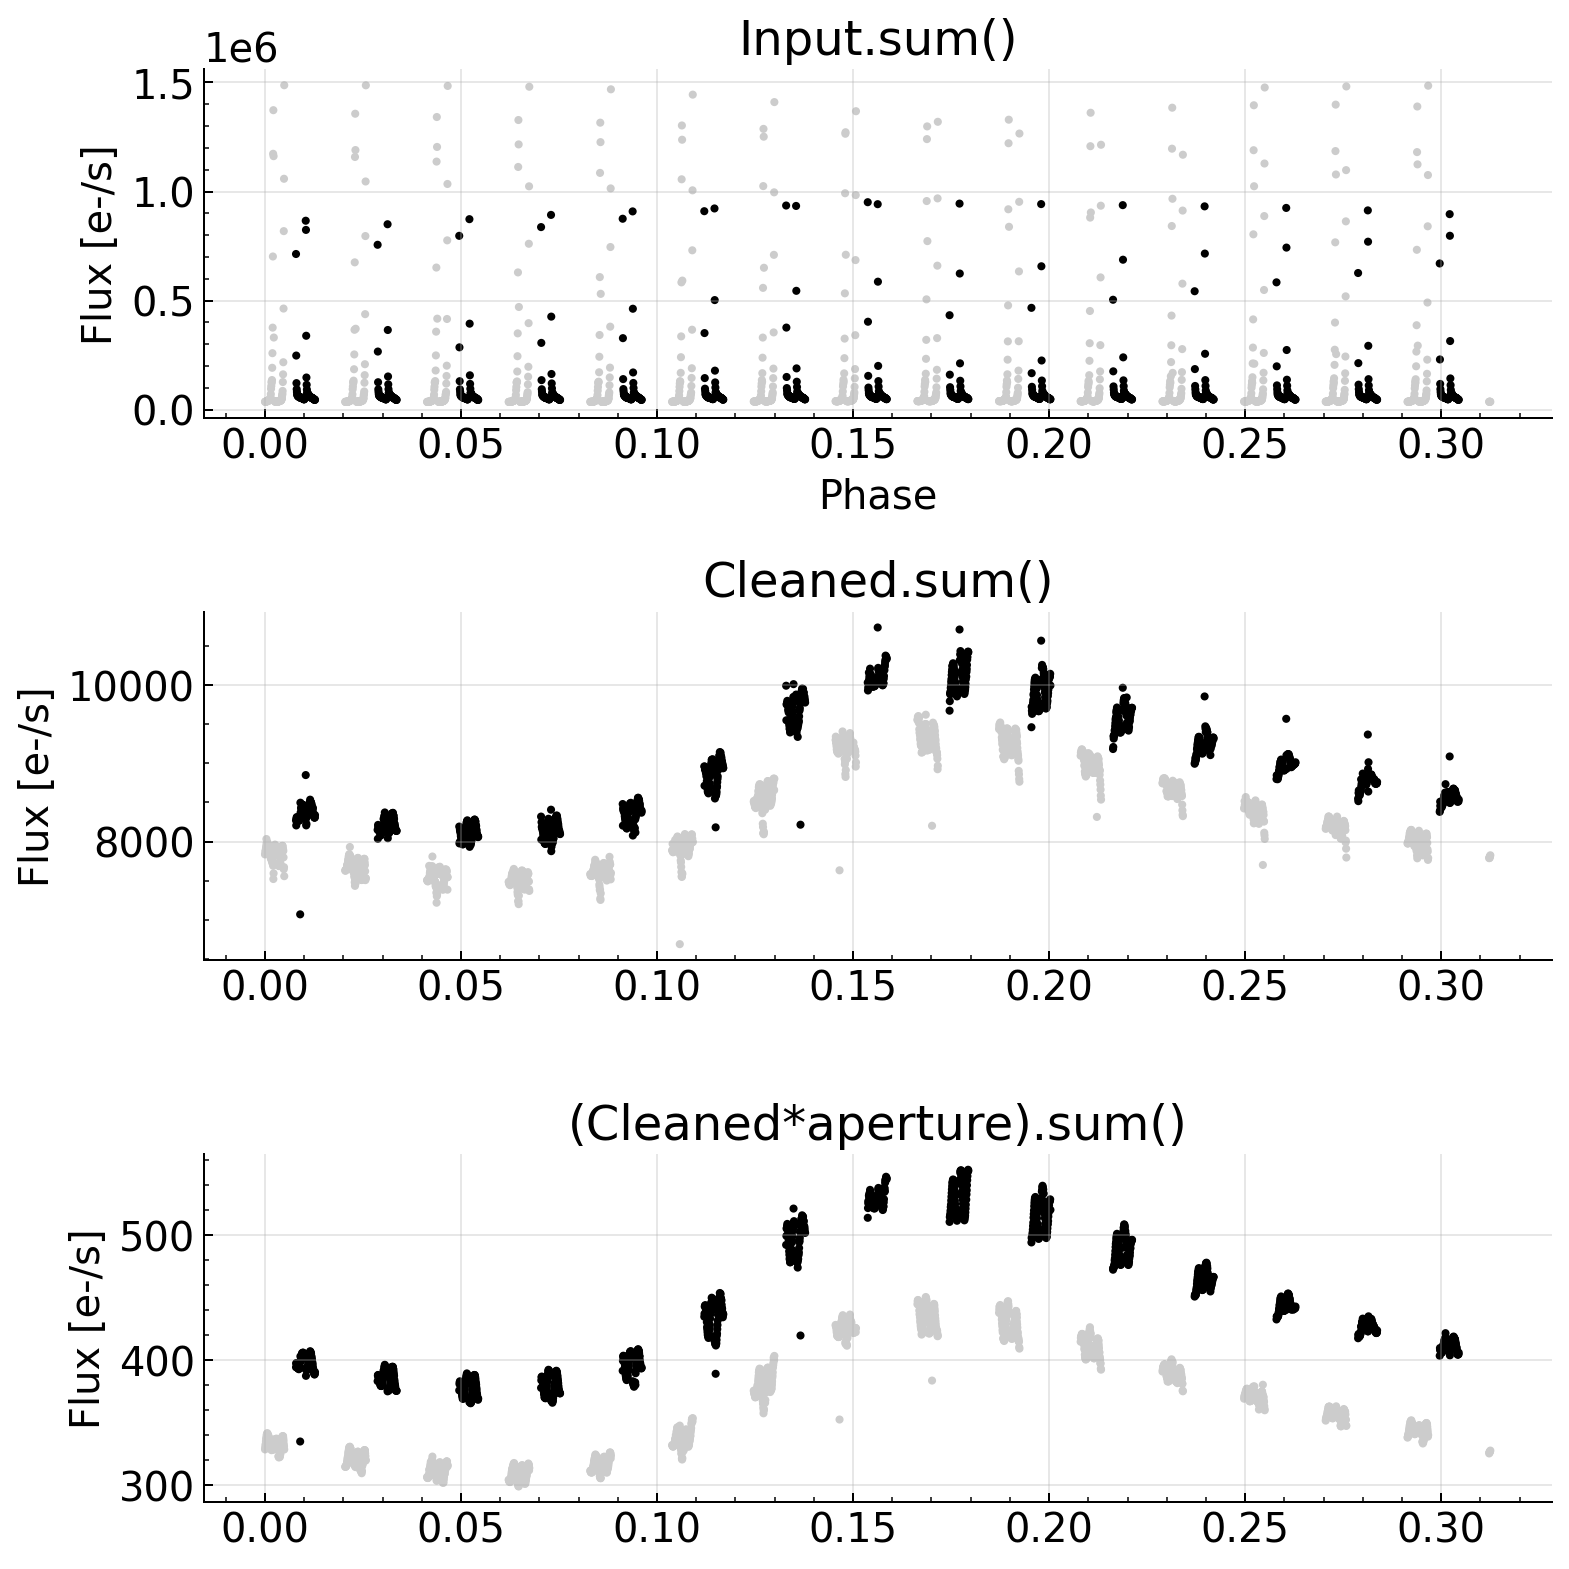

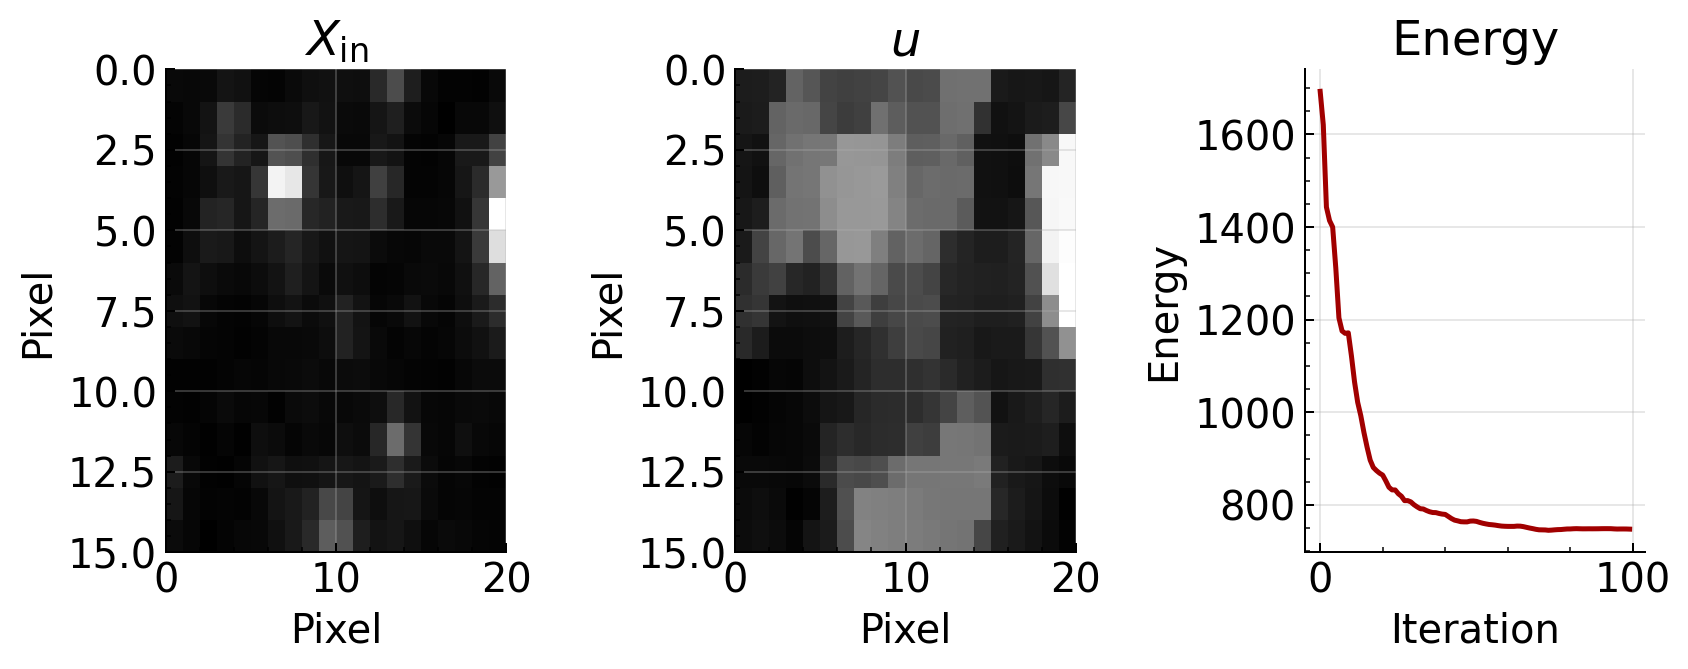

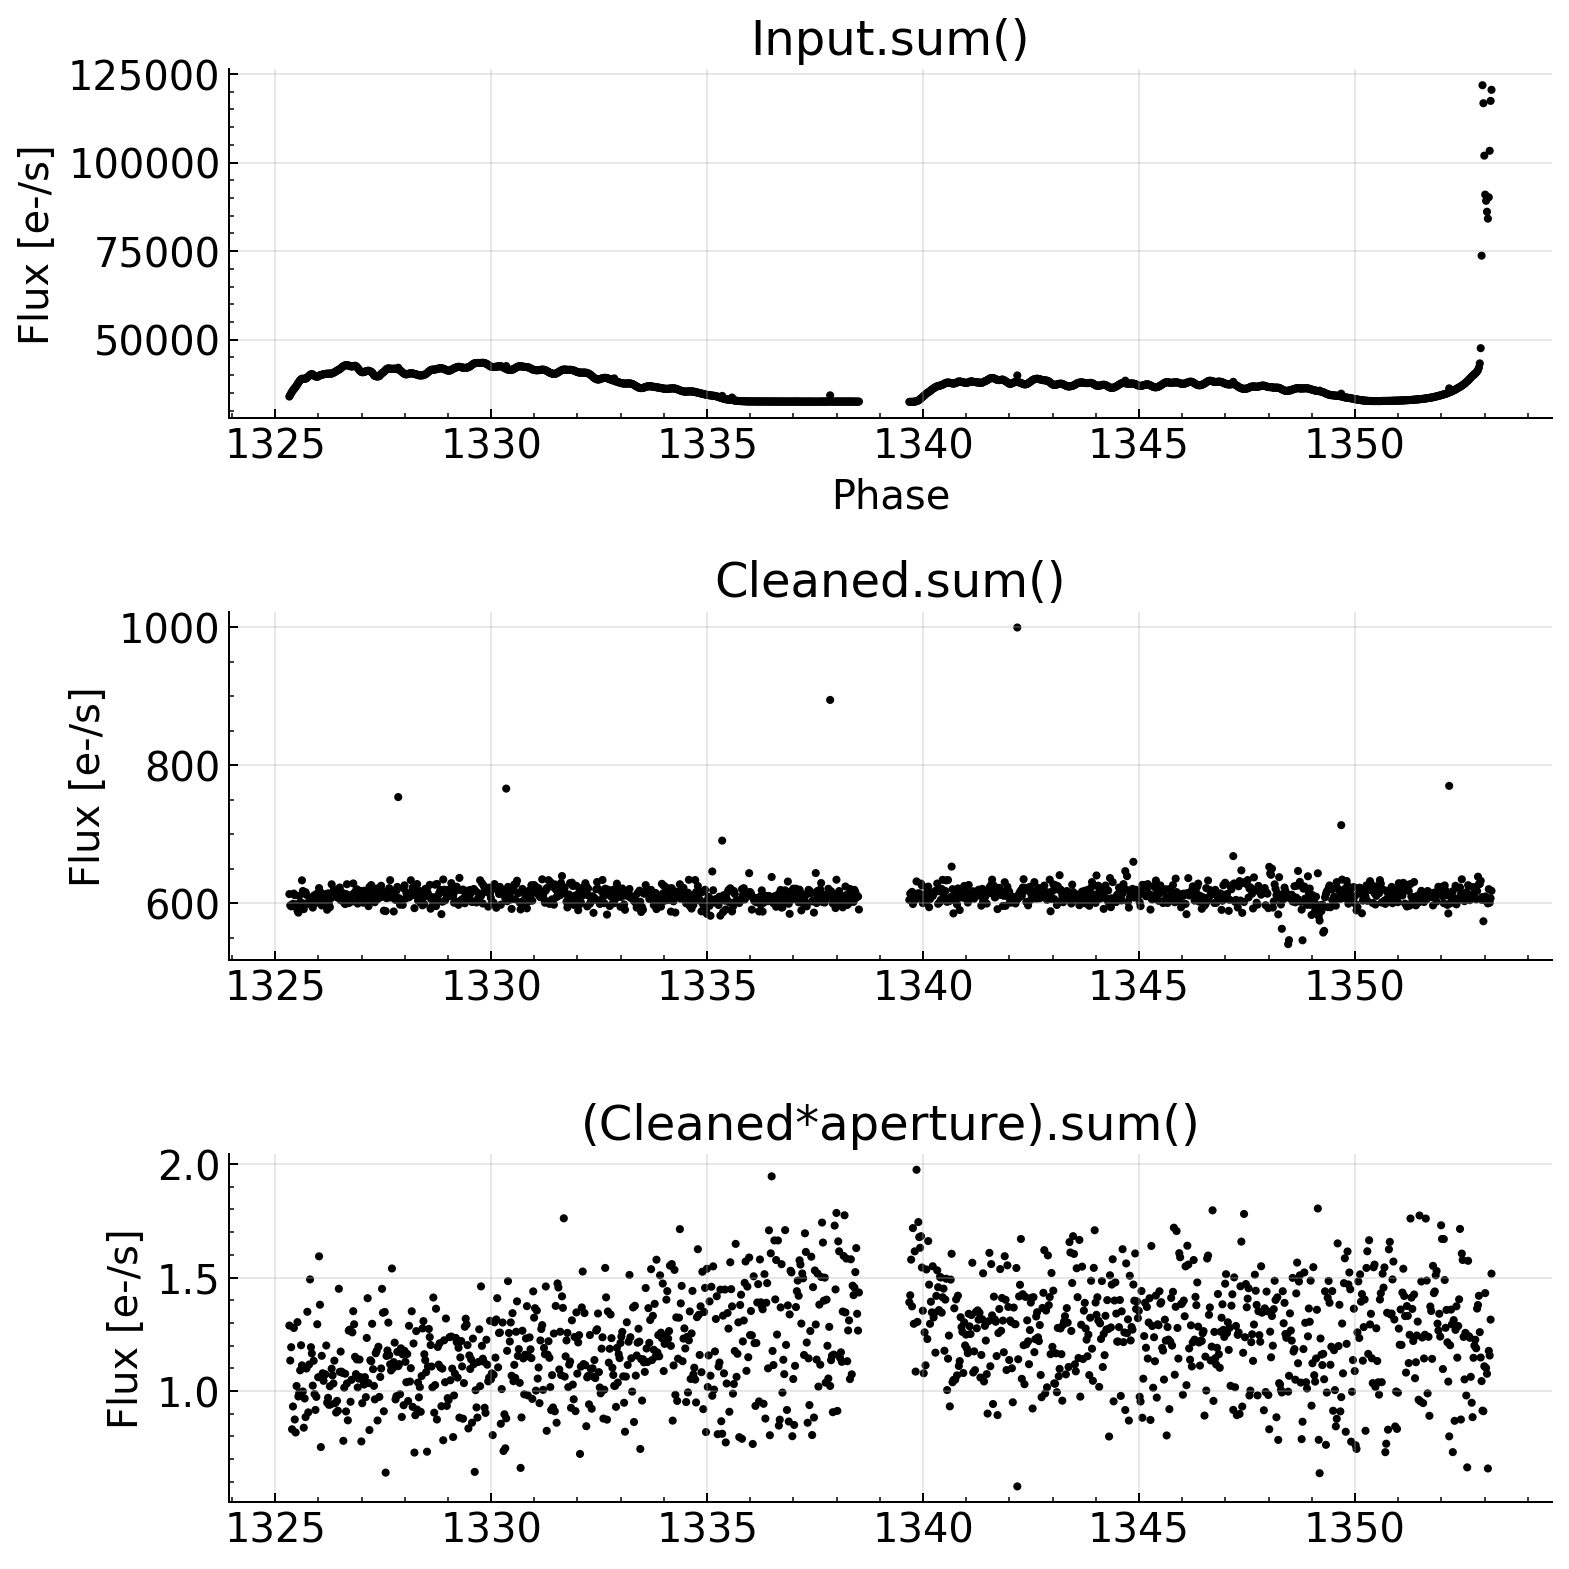

In [35]:
params = [
    dict(lbda=1.5, tau=1000, norm="l1"),    #higher lbda if signature is well visible already (high weight on reconstructing the input)
    dict(lbda=1, tau=100, norm="l1"),       #lower lbda if signature is obscured (allow for "creative" liberty)
    dict(lbda=1, tau=10, norm="l1"),
]

for idx in range(0,len(cutouts)):
# for idx in range(2,3):

    #process each cutout individually
    X_clean = []
    for tidx in range(len(cutouts[idx])):
    # for tidx in range(0,10):
        X_train = cutouts[idx][tidx]
        TV = aldato.TotalVariation(
            theta=1,
            min_iter=2, max_iter=100, eps=1e-6,
            verbose=2,
            **params[idx]
        )        
        TV.fit(X_train)
        X_clean.append(TV.transform())

        #plot last resulting tpf
        # if tidx%1000 == 0:
        if tidx == len(cutouts):
            fig = plt.figure(figsize=(12,4))
            fig, axs = TV.plot_result(X_in=X_train, fig=fig)
            axs[0].invert_yaxis()
            axs[1].invert_yaxis()
            fig.tight_layout()

    X_clean = np.array(X_clean)
    X_clean = cutouts[idx] - X_clean
    #plot result as LCs
    fig2 = plt.figure(figsize=(9,9))
    ax1 = fig2.add_subplot(311, title=f'Input.sum()')
    ax2 = fig2.add_subplot(312, title=f'Cleaned.sum()')
    ax3 = fig2.add_subplot(313, title=f'(Cleaned*aperture).sum()')
    ax1.scatter(times[idx]%df_targets["period"][idx], cutouts[idx].sum(axis=(1,2)),c=sectors[idx], s=5, cmap="nipy_spectral")
    ax2.scatter(times[idx]%df_targets["period"][idx], X_clean.sum(axis=(1,2)),  c=sectors[idx], s=5, cmap="nipy_spectral")

    #applying aperture    
    AP = alprph.Aperture(cutouts[0].shape[1:], npixels=1)
    ap = AP.lp_aperture(radius=2, p=2).reshape(1,*cutouts[0].shape[1:])
    ax3.scatter(times[idx]%df_targets["period"][idx], (X_clean*ap).sum(axis=(1,2)),   c=sectors[idx], s=5, cmap="nipy_spectral")

    ax1.set_xlabel('Phase')
    # ax2.set_xlabel('Phase')
    # ax3.set_xlabel('Phase')
    ax1.set_ylabel('Flux [e-/s]')
    ax2.set_ylabel('Flux [e-/s]')
    ax3.set_ylabel('Flux [e-/s]')

    fig2.tight_layout()

plt.show()